# Overview

This notebook in intended as a generic notebook to be used with the papermill python library to allow automated generation of analyses and reports for finding relationships between microbiome and clinical variables.

In [1]:
cd /project/src

/project/src


In [2]:
from sklearn import model_selection
from sklearn import metrics
import os
import re
import numpy as np
import pandas as pd
from MicroBiome import Trainer, TrainTester, MultiTrainTester, list_transformer, DiffExpTransform, CorTransform, fisher_test_vect
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn import linear_model as LM
from scipy.stats import ttest_ind
import seaborn as sns
import pickle as pk
from matplotlib import pyplot as plt
# Ignore warning messages
if True:
    import warnings
    warnings.filterwarnings('ignore')

In [3]:
np.set_printoptions(precision=2)

# Basic Data Loading

In [4]:
inp_mat_file = '/project/data/raw/justin_paired_end_run_jul_6_2021/PE_50K_freq_mat.csv'
metadata_file = '/project/data/raw/Jie_2017_supp_table_1.xlsx'
identifiers_file = '/project/data/raw/SRA/all_runs.csv'

In [5]:
def read_table(fpath, **kwargs):
    """
    read csv or excel file
    
    fpath = filepath
    **kwargs = other arguments to pandas.read_csv or pandas.read_excel
    
    returns: pandas dataframe
    """
    
    if re.search('\\.xls(x)*$', fpath):
        df = pd.read_excel(fpath, **kwargs)
    elif re.search('\\.csv$', fpath):
        df = pd.read_csv(fpath, **kwargs)
    else:
        raise ValueError('Unexpected file type for file {}'.format(fpath))
        
    return df

In [6]:
inp_mat = read_table(inp_mat_file)
matrix_cols = inp_mat.columns[1:len(inp_mat.columns)]
inp_mat['RunID'] = np.array([re.findall('^[A-Z]{3}[0-9]+', x)[0] for x in inp_mat['filename'].to_numpy().astype('str')])
inp_mat = inp_mat.loc[:, np.concatenate((['filename', 'RunID'], matrix_cols.to_numpy()))]
inp_mat.head()

,filename,RunID,Homo sapiens,Blochmannia endosymbiont of Camponotus (Colobopsis) obliquus,Blochmannia endosymbiont of Camponotus nipponensis,Blochmannia endosymbiont of Colobopsis nipponica,Blochmannia endosymbiont of Polyrhachis (Hedomyrma) turneri,Bovine nidovirus 1,Candidatus Aquiluna sp. 15G-AUS-rot,Candidatus Aquiluna sp. UB-MaderosW2red,...,Lonomia obliqua nucleopolyhedrovirus,Microplitis demolitor bracovirus,Neodiprion sertifer nucleopolyhedrovirus,Oxyplax ochracea nucleopolyhedrovirus,Spodoptera exigua multiple nucleopolyhedrovirus,Spodoptera litura granulovirus,Spodoptera litura nucleopolyhedrovirus,Sulfolobales Mexican fusellovirus 1,Human feces pecovirus,Pacmanvirus A23
0,ERR2017411_seqt.subsampled_1_kneaddata_paired_...,ERR2017411,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ERR2017412_seqt.subsampled_1_kneaddata_paired_...,ERR2017412,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ERR2017413_seqt.subsampled_1_kneaddata_paired_...,ERR2017413,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ERR2017414_seqt.subsampled_1_kneaddata_paired_...,ERR2017414,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ERR2017415_seqt.subsampled_1_kneaddata_paired_...,ERR2017415,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
meta_data = read_table(metadata_file, skiprows=2)
meta_data.head()

,Sample ID,ACVD status,Coronary type,Age (year),Gender,Height (cm),Weight (kg),Body Mass Index (BMI),Waist (cm),Hip (cm),...,Bisoprolol_9,Fondaparinux Sodium_10,Metoprolol_19,Insulin aspart_6,Isosorbide dinitrate_10,Acarbose_7,Captopril Tablets_6,Estazolam_6,Nitroglycerin Tablets_8,Potassium chloride_32
0,N001,0,NaN,52.0,male,165.0,65.0,23.88,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,N002,0,NaN,53.0,male,160.0,63.0,24.61,78.0,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,N003,0,NaN,48.0,male,166.0,70.0,25.40,92.0,98.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,N005,0,NaN,53.0,female,158.0,57.5,23.03,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,N006,0,NaN,53.0,female,150.0,60.0,26.67,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
meta_data['Sample ID']

0        N001
1        N002
2        N003
3        N005
4        N006
        ...  
400    ZSL525
401    ZSL527
402    ZSL529
403    ZSL530
404    ZSL532
Name: Sample ID, Length: 405, dtype: object

In [9]:
identifiers = read_table(identifiers_file)
identifiers['Sample ID'] = identifiers.pop('Alias')
identifiers.head()

,Unnamed: 0,ExptAcc,RunID,Sample ID
0,0,ERX2076993,ERR2017411,N001
1,0,ERX2076994,ERR2017412,N002
2,0,ERX2076995,ERR2017413,N003
3,0,ERX2076996,ERR2017414,N005
4,0,ERX2076997,ERR2017415,N006


In [10]:
identifiers['Sample ID']

0        N001
1        N002
2        N003
3        N005
4        N006
        ...  
400    ZSL_58
401    ZSL_67
402     ZSL_6
403    ZSL_82
404    ZSL_96
Name: Sample ID, Length: 405, dtype: object

In [11]:
identifiers['Sample ID'] = identifiers['Sample ID'].astype('str')
meta_data['Sample ID'] = meta_data['Sample ID'].astype('str')
meta_data_full = pd.merge(identifiers, meta_data, how='left', on='Sample ID')
meta_data_full.head()

,Unnamed: 0,ExptAcc,RunID,Sample ID,ACVD status,Coronary type,Age (year),Gender,Height (cm),Weight (kg),...,Bisoprolol_9,Fondaparinux Sodium_10,Metoprolol_19,Insulin aspart_6,Isosorbide dinitrate_10,Acarbose_7,Captopril Tablets_6,Estazolam_6,Nitroglycerin Tablets_8,Potassium chloride_32
0,0,ERX2076993,ERR2017411,N001,0,NaN,52.0,male,165.0,65.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,ERX2076994,ERR2017412,N002,0,NaN,53.0,male,160.0,63.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,ERX2076995,ERR2017413,N003,0,NaN,48.0,male,166.0,70.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,ERX2076996,ERR2017414,N005,0,NaN,53.0,female,158.0,57.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,ERX2076997,ERR2017415,N006,0,NaN,53.0,female,150.0,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
meta_data_full.shape

(405, 58)

# Assemble and Clean Data

In [13]:
meta_data_full = meta_data_full.set_index('RunID')
meta_data_full = meta_data_full.loc[inp_mat['RunID'], :]
inp_mat = inp_mat.set_index('RunID')
# pop filenames from data frame
inp_mat.pop('filename')

RunID
ERR2017411    ERR2017411_seqt.subsampled_1_kneaddata_paired_...
ERR2017412    ERR2017412_seqt.subsampled_1_kneaddata_paired_...
ERR2017413    ERR2017413_seqt.subsampled_1_kneaddata_paired_...
ERR2017414    ERR2017414_seqt.subsampled_1_kneaddata_paired_...
ERR2017415    ERR2017415_seqt.subsampled_1_kneaddata_paired_...
                                    ...                        
ERR2017809    ERR2017809_seqt.subsampled_1_kneaddata_paired_...
ERR2017810    ERR2017810_seqt.subsampled_1_kneaddata_paired_...
ERR2017813    ERR2017813_seqt.subsampled_1_kneaddata_paired_...
ERR2017814    ERR2017814_seqt.subsampled_1_kneaddata_paired_...
ERR2017815    ERR2017815_seqt.subsampled_1_kneaddata_paired_...
Name: filename, Length: 385, dtype: object

In [14]:
feat_meta = pd.DataFrame({'feature': inp_mat.columns.to_numpy().astype('str')})
feat_meta

,feature
0,...
1,Blochmannia endosymbio...
2,Blochmannia endosymbio...
3,Blochmannia endosymbio...
4,Blochmannia endosymbio...
...,...
6496,Spodoptera litura granulovirus
6497,Spodoptera litura nucleopolyhedrovirus
6498,Sulfolobales Mexican fusellovirus 1
6499,Human feces pecovirus


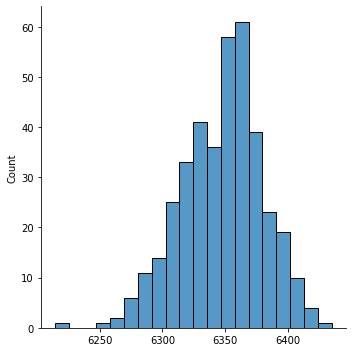

In [15]:
X = inp_mat.to_numpy().astype('float32')
X[np.isnan(X)] = 0.
zero_feats = [np.sum(X[i,:] == 0.) for i in range(X.shape[0])]
sns.displot(zero_feats)

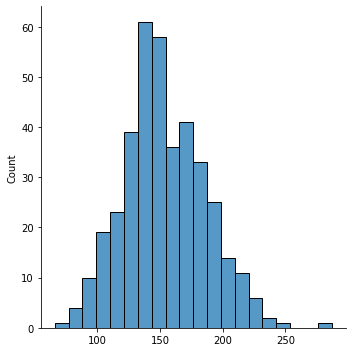

In [16]:
nonzero_feats = [np.sum(X[i,:] != 0.) for i in range(X.shape[0])]
sns.displot(nonzero_feats)

In [17]:
X_centered = X - (X.sum(axis=0)/X.shape[1])
col_vars = np.power(X_centered, 2).sum(axis=0)/X.shape[1]

In [18]:
sum(col_vars == 0)

4559

In [19]:
feats_keep = col_vars != 0
X = X[:, feats_keep]
inp_mat = inp_mat.iloc[:, feats_keep]
feat_meta = feat_meta.iloc[feats_keep, :]
X.shape

(385, 1942)

In [20]:
# check that all values of x are gte 0
assert np.all(X >= 0)

In [21]:
# these samples, if they exist, have 0 detected features
zero_samples = X.sum(axis=1) == 0
# if this is True, then we'd need to remove some samples
any_zero_samples = np.any(zero_samples)
any_zero_samples

False

In [22]:
if any_zero_samples:
    samples_keep = np.logical_not(zero_samples)
    X = X[samples_keep, :]
    meta_data_full = meta_data_full.iloc[samples_keep, :]

In [23]:
print(X.shape)
print(meta_data_full.shape)

(385, 1942)
(385, 57)


In [24]:
meta_data_full.columns

Index(['Unnamed: 0', 'ExptAcc', 'Sample ID', 'ACVD status', 'Coronary type',
       'Age (year)', 'Gender', 'Height (cm)', 'Weight (kg)',
       'Body Mass Index (BMI)', 'Waist (cm)', 'Hip (cm)',
       'Waist Hip Ratio (WHR)', 'Smoking', 'Systolic Blood Pressure (mmHg)',
       'Diastolic Blood Pressure (mmHg)', 'FBG', 'TRIG (mmol/L)',
       'LDLC (mmol/L)', 'CHOL (mmol/L)', 'HDLC (mmol/L)', 'APOB (mg/dl)',
       'APOA (mg/dl)', 'Lpa (mg/dl)', 'HbA1c (%)', 'CKMB (U/L)', 'ALB (U/L)',
       'ALT (U/L)', 'TP (g/L)', 'AST (U/L)', 'CREA (umol/L)', 'CK (U/L)',
       'ProBNP E (Pg/ml)', 'CRP (mg/l)', 'HBDH (U/L）', 'DBIL (umol/L)',
       'BUN (nmol/L)', 'TBIL (umol/L)', 'URIC (umol/L)',
       'Clopidogrel Hydrogen Sulphate Tablets_117', 'Aspirin_33',
       'Atorvastatin_25', 'Esomeprazole_9', 'Isosorbide Mononitrate_11',
       'Potassium Citrate_14', 'Perindopril_15', 'Heparin Sodium_10',
       'Bisoprolol_9', 'Fondaparinux Sodium_10', 'Metoprolol_19',
       'Insulin aspart_6', 'Iso

In [25]:
meta_data_full.columns.dtype 

dtype('O')

In [26]:
for i in range(3, len(meta_data_full.columns)):
    col_name = meta_data_full.columns[i]
    print(col_name)
    x = meta_data_full[col_name].to_numpy()
    if x.dtype is np.dtype('object'):
        x = x.astype('str')
        print(pd.DataFrame({'x': x}).value_counts('x'))
    else:
        nan_count = np.sum(np.isnan(x))
        print('{} (nan) {} (data exists)'.format(nan_count, len(x) - nan_count))

ACVD status
0 (nan) 385 (data exists)
Coronary type
x              
Stable angina      202
nan                171
Unstable angina      7
AMI                  5
dtype: int64
Age (year)
7 (nan) 378 (data exists)
Gender
x     
male      226
female    154
nan         5
dtype: int64
Height (cm)
70 (nan) 315 (data exists)
Weight (kg)
66 (nan) 319 (data exists)
Body Mass Index (BMI)
72 (nan) 313 (data exists)
Waist (cm)
261 (nan) 124 (data exists)
Hip (cm)
263 (nan) 122 (data exists)
Waist Hip Ratio (WHR)
263 (nan) 122 (data exists)
Smoking
x      
nan        351
no          23
smoking     11
dtype: int64
Systolic Blood Pressure (mmHg)
200 (nan) 185 (data exists)
Diastolic Blood Pressure (mmHg)
200 (nan) 185 (data exists)
FBG
188 (nan) 197 (data exists)
TRIG (mmol/L)
38 (nan) 347 (data exists)
LDLC (mmol/L)
38 (nan) 347 (data exists)
CHOL (mmol/L)
38 (nan) 347 (data exists)
HDLC (mmol/L)
40 (nan) 345 (data exists)
APOB (mg/dl)
67 (nan) 318 (data exists)
APOA (mg/dl)
66 (nan) 319 (data exists)

In [27]:
meta_data_full['ACVD status'].value_counts()


1    214
0    171
Name: ACVD status, dtype: int64

In [28]:
np.any(np.isnan(meta_data_full['ACVD status'].to_numpy()))

False

In [29]:
meta_data_full['Gender'].value_counts()

male      226
female    154
Name: Gender, dtype: int64

In [30]:
y = meta_data_full['ACVD status'].to_numpy().astype('int32')

In [31]:
y.shape

(385,)

# Assess Associations of Clinical, Microbiome Variables

In [32]:
# check association of clinical variables

# gender
gender_vect = meta_data_full['Gender'].to_numpy().astype('str')
gender_not_nan = gender_vect != 'nan'
fisher_test_vect(gender_vect[gender_not_nan], y[gender_not_nan], 'male', 1, alternative='greater')

contingency table
[[157  69]
 [ 53 101]]
odds ratio: 4.336067815149029; pval 1.1397605964582858e-11


(array([[157,  69],
        [ 53, 101]]),
 4.336067815149029,
 1.1397605964582858e-11)

In [33]:
meta_data_full['Age (year)'].to_numpy()

array([ 52.  ,  53.  ,  48.  ,  53.  ,  53.  ,  60.  ,  69.  ,  61.  ,
        44.  ,  56.  ,  54.  ,  41.  ,  55.  ,  50.  ,  40.  ,  55.  ,
        54.  ,  67.  ,  67.  ,  38.  ,  45.  ,  56.  ,  53.  ,  52.  ,
        55.  ,  52.  ,  47.  ,  55.  ,  50.  ,  56.  ,  58.  ,  70.  ,
        60.  ,  46.  ,  61.  ,  40.  ,  43.  ,  60.  ,  52.  ,  54.  ,
        57.  ,  56.  ,  53.  ,  59.  ,  57.  ,  50.  ,  62.  ,  50.  ,
        55.  ,  74.  ,  73.  ,  72.  ,  65.  ,  77.  ,  84.  ,  74.  ,
        69.  ,  65.  ,  67.  ,  65.  ,  51.  ,  54.  ,  53.  ,  51.  ,
        61.  ,  61.  ,  59.  ,  62.  ,  58.  ,  60.  ,  58.  ,  70.  ,
        66.  ,  57.  ,  56.  ,  56.  ,  59.  ,  67.  ,  57.  ,  53.  ,
        69.  ,  65.  ,  58.  ,  57.  ,  55.  ,  59.  ,  63.  ,  59.  ,
        64.  ,  59.  ,  62.  ,  53.  ,  61.  ,  61.  ,  68.  ,  80.  ,
        71.  ,  74.  ,  65.  ,  66.  ,  79.  ,  70.  ,  66.  ,  65.  ,
        74.  ,  79.  ,  69.  , 107.  ,    nan,  63.  ,  56.  ,  58.  ,
      

In [34]:
# age
age_vect = meta_data_full['Age (year)'].to_numpy()
age_not_nan = np.logical_not(np.isnan(age_vect))
print(np.sum(age_not_nan))
ttest_ind(age_vect[age_not_nan][y[age_not_nan] == 1], age_vect[age_not_nan][y[age_not_nan] == 0])

378


Ttest_indResult(statistic=0.6030663996184584, pvalue=0.5468280984304414)

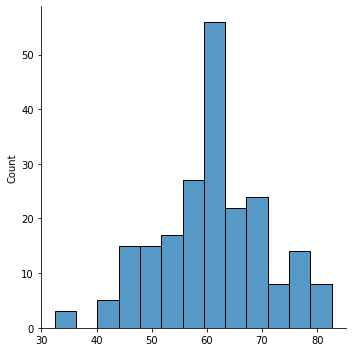

In [35]:
sns.displot(age_vect[age_not_nan][y[age_not_nan] == 1])

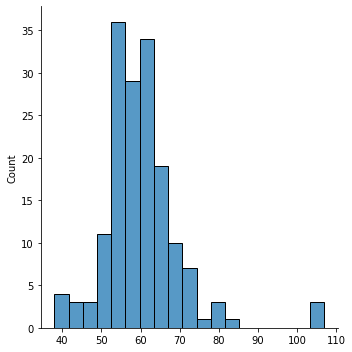

In [36]:
sns.displot(age_vect[age_not_nan][y[age_not_nan] == 0])

In [37]:
# BMI
bmi_vect = meta_data_full['Body Mass Index (BMI)'].to_numpy()
bmi_not_nan = np.logical_not(np.isnan(bmi_vect))
print(np.sum(bmi_not_nan))
ttest_ind(bmi_vect[bmi_not_nan][y[bmi_not_nan] == 1], bmi_vect[bmi_not_nan][y[bmi_not_nan] == 0])

313


Ttest_indResult(statistic=0.19394592250893994, pvalue=0.8463448413490583)

In [38]:
# systolic blood pressure
systolic_vect = meta_data_full['Systolic Blood Pressure (mmHg)'].to_numpy()
systolic_not_nan = np.logical_not(np.isnan(systolic_vect))
print(np.sum(systolic_not_nan))
ttest_ind(systolic_vect[systolic_not_nan][y[systolic_not_nan] == 1], systolic_not_nan[systolic_not_nan][y[systolic_not_nan] == 0])

185


Ttest_indResult(statistic=79.4045614221356, pvalue=9.591397011967446e-144)

In [39]:
# diastolic blood pressure
diastolic_vect = meta_data_full['Diastolic Blood Pressure (mmHg)'].to_numpy()
diastolic_not_nan = np.logical_not(np.isnan(systolic_vect))
print(np.sum(diastolic_not_nan))
ttest_ind(diastolic_vect[diastolic_not_nan][y[diastolic_not_nan] == 1], diastolic_vect[diastolic_not_nan][y[diastolic_not_nan] == 0])

185


Ttest_indResult(statistic=0.9908841203369072, pvalue=0.3230505234221328)

Given that we only have used Age, BMI, and gender in our models thus far, it is more than likely that gender is giving the highest amount of performance gain to our model relative to differentially abundant microbiota alone.

## Get Differentially Expressed Features, ACVD vs non-ACVD

In [40]:
DE = DiffExpTransform()
DE.fit(X[gender_not_nan, :], y[gender_not_nan])

In [41]:
# ACVD negative associated features
DE.results['0'][DE.results['0']['rejected'] == True].head()

,tstat,pval,p_adj,rejected
16,5.056063,3.342401e-07,NaN,True
30,4.244579,1.379456e-05,NaN,True
31,4.430747,6.158420e-06,NaN,True
33,3.326473,4.828571e-04,NaN,True
99,3.321044,4.920750e-04,NaN,True


In [42]:
DE.results['0'][DE.results['0']['rejected'] == True].shape[0]

27

In [43]:
# ACVD positive associated features
DE.results['1'][DE.results['1']['rejected'] == True].head()

,tstat,pval,p_adj,rejected
237,4.254159,0.000013,NaN,True
247,3.931674,0.000050,NaN,True
333,4.449814,0.000006,NaN,True
364,3.430883,0.000334,NaN,True
366,3.454073,0.000307,NaN,True


In [44]:
DE.results['1'][DE.results['1']['rejected'] == True].shape[0]

58

## Get Differentially Expressed Features, Male vs Female

Weirdly enough, it doesn't appear that through a simple t-test we detect differentially abundant features between male and female individuals. We are probably underpowered for detecting differences between male and female microbiomes, due to the nature of assuming normally distributed data and using data bound between 0 and 1. However, this suggests, that the differences between male and female microbiota are not large enough to result in features that are detectably different to the extent that they are in at least a subset of ACVD and non-ACVD samples

In [45]:
DE_MF = DiffExpTransform()
DE_MF.fit(X[gender_not_nan, :], (gender_vect[gender_not_nan] == 'male').astype('int64'))

In [46]:
# female associated features
print('no. features {}'.format(DE_MF.results['0'][DE_MF.results['0']['rejected'] == True].shape[0]))
DE_MF.results['0'][DE_MF.results['0']['rejected'] == True].head()

no. features 0


,tstat,pval,p_adj,rejected


In [47]:
# male associated features
print('no. features {}'.format(DE_MF.results['1'][DE_MF.results['1']['rejected'] == True].shape[0]))
DE_MF.results['1'][DE_MF.results['1']['rejected'] == True].head()

no. features 0


,tstat,pval,p_adj,rejected
